In [8]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import imutils
from skimage import measure
from imutils import perspective

In [9]:
def plot_image(image, cmap=None):
    plt.imshow(image, cmap=cmap)
    plt.show()

In [37]:
def increase_brightness(image, value):
    # Convert the image to HSV format
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Split the image into its channels
    h, s, v = cv2.split(hsv)
    
    # Increase the V channel by the specified value
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value
    
    # Merge the channels back together
    final_hsv = cv2.merge((h, s, v))
    
    # Convert the image back to BGR format
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    
    return img

In [10]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [11]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                LP_WIDTH/2,
                LP_HEIGHT/10,
                2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

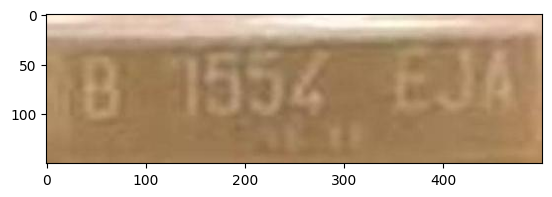

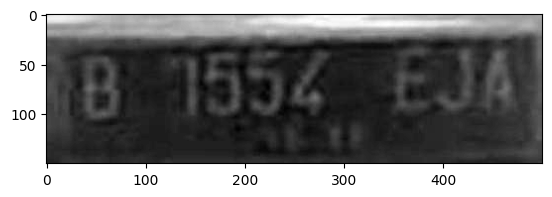

In [24]:
img_path = './data-modified-resized/train/data/DataTrain10.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
gray = cv2.imread(img_path, 0)
plot_image(img)
plot_image(gray, 'gray')

#### denoise

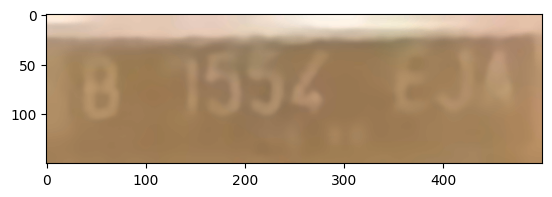

In [49]:
denoised = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
plot_image(denoised, 'gray')

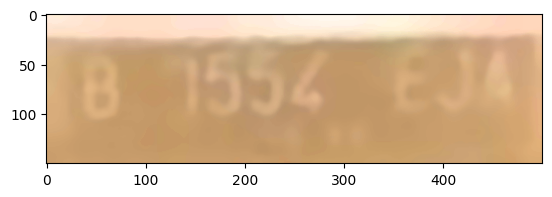

In [50]:
# Increase the brightness by a value of 30
bright_img = increase_brightness(denoised, 40)
plot_image(bright_img)

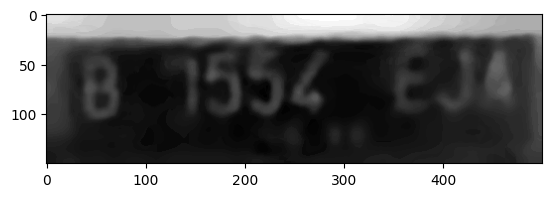

In [51]:
denoised = cv2.cvtColor(bright_img, cv2.COLOR_BGR2GRAY)
plot_image(denoised, 'gray')

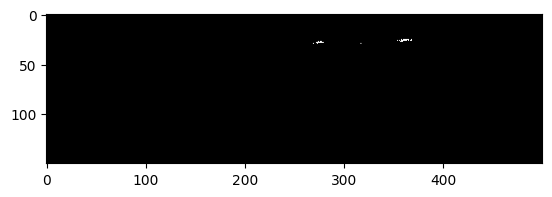

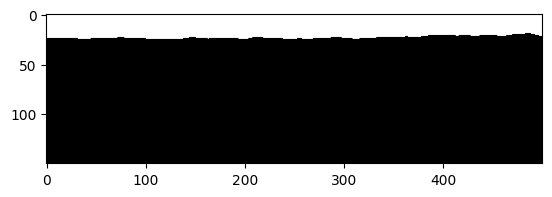

In [36]:
img_thresh = cv2.adaptiveThreshold(
    denoised, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

(thresh, img_thresh_otsu) = cv2.threshold(denoised, 10, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plot_image(img_thresh, 'gray')
plot_image(img_thresh_otsu, 'gray')

#### maximize contrast

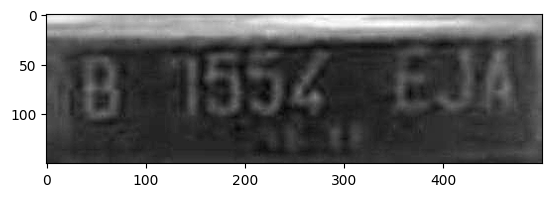

In [25]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
max_contrast = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plot_image(max_contrast, 'gray')